In [63]:
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
import pandas as pd

In [64]:
# Load the strain rate file calculted using strain_2D
file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain2D/Strain_2D/example/Output/gpsgridder/NC_files/MYM_ITRF_gpsgridder_strain.nc'
ds = xr.open_dataset(file_path)

# Check the available variables in the dataset
# ds.variables

In [65]:
# Extract max shear strain data
max_shear_strain = ds['max_shear'].values
latitudes = ds['y'].values
longitudes = ds['x'].values

# Normalize max shear strain data to range between 0 and 1
# max_shear_strain_normalized = (max_shear_strain - np.min(max_shear_strain)) / (np.max(max_shear_strain) - np.min(max_shear_strain))

In [78]:
# Load the earthquake data
earthquake_file_path = '../data/mainshocks_Reasenberg.csv'
earthquake_data = pd.read_csv(earthquake_file_path)

# Updated region based on new coordinates
min_lat, max_lat = 15, 28
min_lon, max_lon = 90, 98

# Filter the earthquake data for the updated coordinates and time period
filtered_earthquake_locations_update = earthquake_data[
    (earthquake_data['latitude'] >= min_lat) &
    (earthquake_data['latitude'] <= max_lat) &
    (earthquake_data['longitude'] >= min_lon) &
    (earthquake_data['longitude'] <= max_lon) &
    # (earthquake_data['date'] >= '1998-01-01') &
    # (earthquake_data['date'] <= '2018-12-31') &
    (earthquake_data['magnitude'] >= 3.8) &
    (earthquake_data['depth'] <= 30)
]
# Display the first few rows of the earthquake data to understand its structure
# filtered_earthquake_locations_update.magnitude.max()
# Extract the first 10 columns
# earthquake_data_10cols = earthquake_data.iloc[:, :12]

# # Print the column names to verify
# print("Column names in the first 10 columns:")
# print(earthquake_data_10cols.columns)

# # Print the first few rows to verify
# print("\nPreview of the first 10 columns of the earthquake catalog data:")
# print(earthquake_data_10cols.head())

In [67]:
filtered_earthquake_locations_update.date.min()

'1904-08-30'

In [68]:
# Load GPS data
gps_file = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain2D/data/GPS_data/mymr_vel_space_ITRF2014.txt'  # Replace with your file path
gps_data = np.genfromtxt(gps_file, delimiter=' ', skip_header=1, usecols=(0, 1))

# Extract longitudes and latitudes
gps_longitudes = gps_data[:, 0]
gps_latitudes = gps_data[:, 1]

# # Print to check if data is loaded correctly
# print("GPS Longitudes:", gps_longitudes)
# print("GPS Latitudes:", gps_latitudes)

In [69]:
# # # Load fault data
fault_file = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain2D/data/MYM_geo_structure/2014_active_fault_data/Active_str_merge_2014.shp'  # Replace with your shapefile path
fault_data = gpd.read_file(fault_file)

# Filter fault data based on coordinate boundaries
# fault_data = fault_data.cx[min_lon:max_lon, min_lat:max_lat]

/Users/zuhair/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/zuhair/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


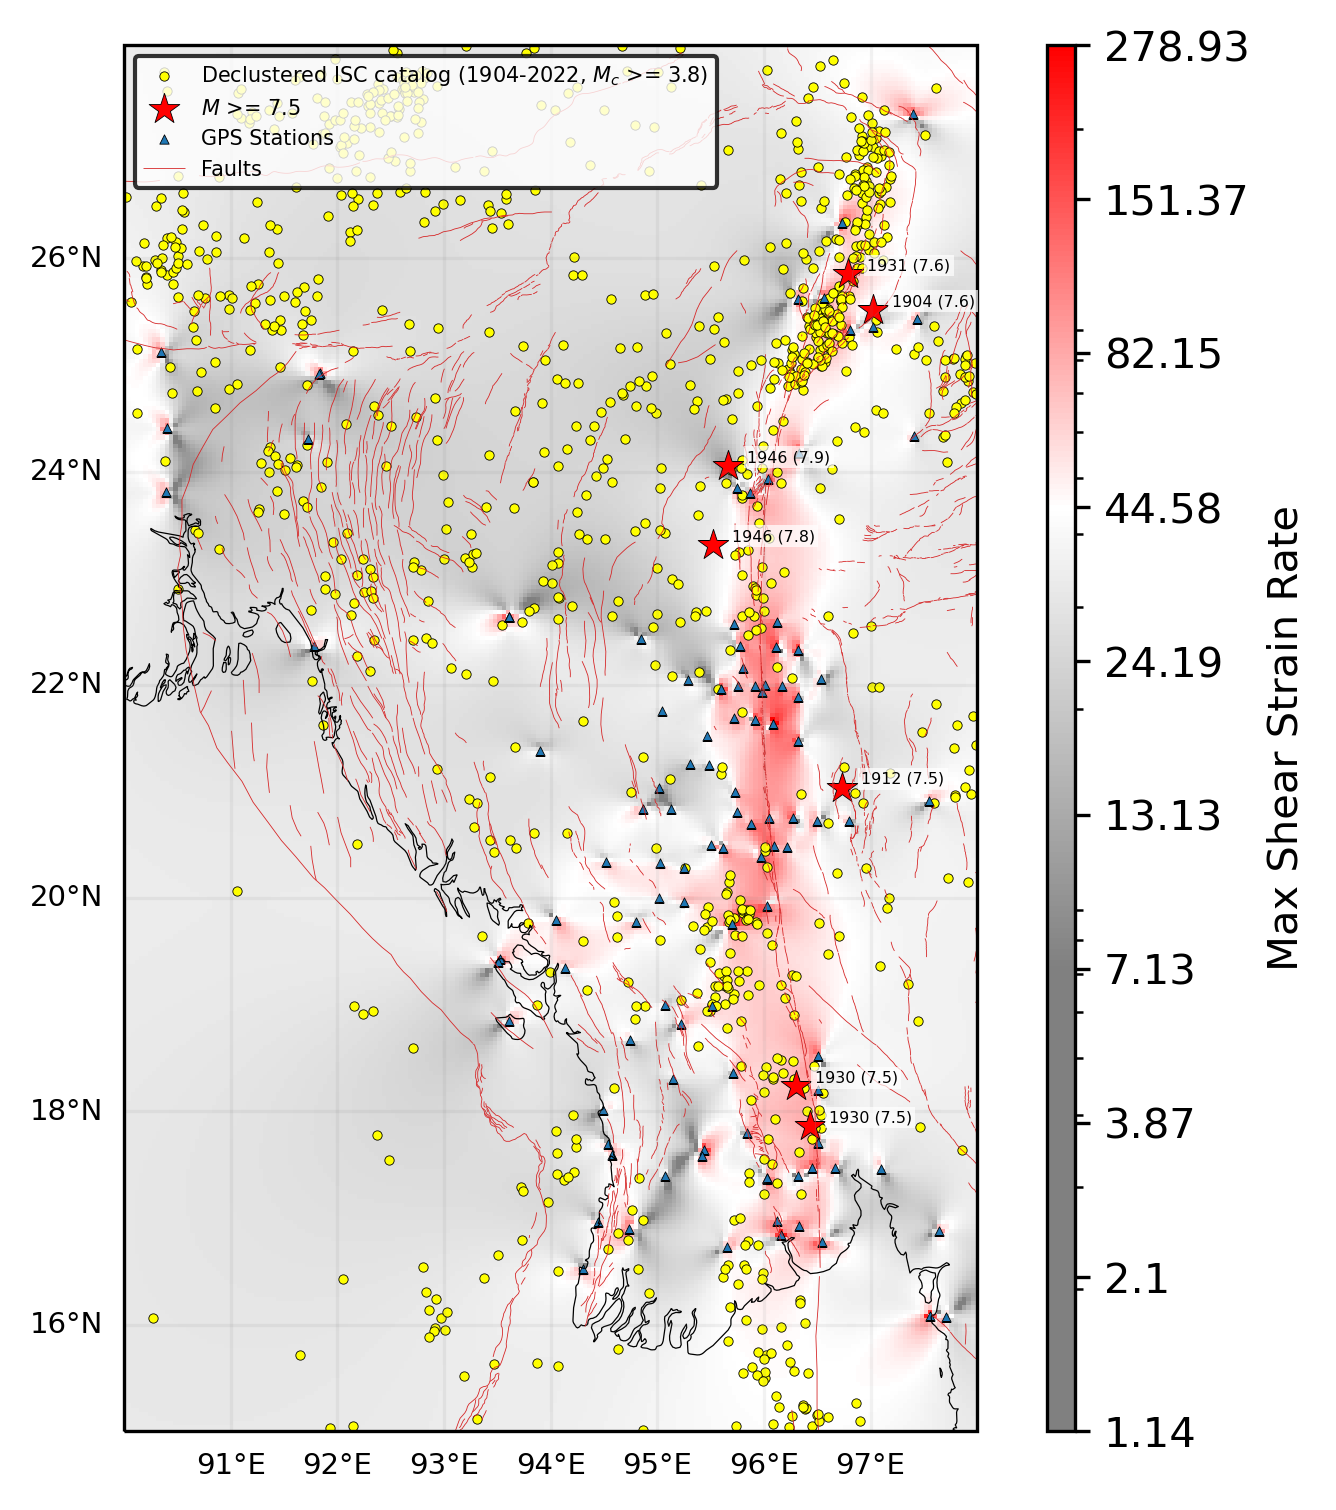

In [75]:
# Create the plot with Cartopy
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add features to the map
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.COASTLINE)
# ax.gridlines(draw_labels=True)
ax.coastlines(resolution='10m', color='black', linewidth=0.3)
# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.1, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 7, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'size': 7, 'color': 'black'}

# Define a custom colormap for the max shear strain rate
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['grey', 'grey', 'white', 'red'])

# Plot the max shear strain rate as the background with the custom color scheme
img = ax.pcolormesh(longitudes, latitudes, max_shear_strain, cmap=cmap_custom, norm=mcolors.LogNorm(), transform=ccrs.PlateCarree())


# Overlay the seismicity counts with white dots and black boundaries
plt.scatter(filtered_earthquake_locations_update['longitude'], filtered_earthquake_locations_update['latitude'], 
            c='yellow', marker='o', s=5, edgecolor='k', linewidth=0.2, label='Declustered ISC catalog (1904-2022, $M_c$ >= 3.8)', transform=ccrs.PlateCarree())

# large earthquakes

# Convert the date column to datetime
earthquake_data['date'] = pd.to_datetime(earthquake_data['date'])

mag = 7.5
df = earthquake_data[earthquake_data['magnitude'] >= mag]
plt.scatter(df['longitude'], df['latitude'], 
            c='red', marker='*', s=60, edgecolor='k', linewidth=0.2, label='$M$ >= 7.5', transform=ccrs.PlateCarree())

# Annotate each large earthquake with its magnitude and year
for _, row in df.iterrows():
    plt.annotate(f'{row["date"].year} ({row["magnitude"]})', 
                 xy=(row['longitude'], row['latitude']), 
                 xytext=(24.5, 1), textcoords='offset points', fontsize=3.8, ha='right',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.8), transform=ccrs.PlateCarree())

# Overlay the GPS stations with red dots
plt.scatter(gps_longitudes, gps_latitudes, 
            c='tab:blue', marker='^', s=5, edgecolor='black', linewidth=0.2, label='GPS Stations', transform=ccrs.PlateCarree())

# Overlay the fault lines
fault_data.plot(ax=ax, color='tab:red', linewidth=0.2, label='Faults', transform=ccrs.PlateCarree())
# geofeatures.plot(ax=ax, edgecolor='k', linewidth=0.5, transform=ccrs.PlateCarree())

# Add a color bar for the max shear strain rate
cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.05, aspect=50)
cbar.set_label('Max Shear Strain Rate')

# Modify the color bar to show actual values
tick_labels = np.round(np.logspace(np.log10(np.min(max_shear_strain)), np.log10(np.max(max_shear_strain)), num=10), decimals=2)
cbar.set_ticks(tick_labels)
cbar.set_ticklabels([str(round(val, 2)) for val in tick_labels])

# Add labels and title
# plt.title('Seismicity (1998-2018, $M_c$ >= 3.8)')
plt.legend(fontsize='5', loc='upper left', frameon=True, facecolor='white', edgecolor='k')

# Save the figure to an 'output' folder
# output_dir = 'output'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# plt.savefig(os.path.join(output_dir, 'seismicity_max_shear_strain_map(1904-2022).png'), bbox_inches='tight')

plt.show()